In [13]:

import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [14]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region):
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
##==========legned setting 
    figmap.plot(x=40.5,y=39.1,style="c0.5c", pen="black", no_clip=True)
    figmap.text(x=40.5,y=38.9,text='Null', font="12p,Times-Bold,black", no_clip=True)
    RCdata = [[41.5, 39.1, 0, 5, 1*40]]
    SCdata = [[41.5, 38.9, 0, 5, 1*40]]
    figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=39.1,text='RC', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=38.9,text='SC', font="12p,Times-Bold,black", no_clip=True)
    legenddata=[[43, 39.1, 0, 5, 0.5*40],[43.8, 39.1, 0, 5, 1*40],[44.8, 39.1, 0, 5, 1.5*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=43,y=38.9,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=43.8,y=38.9,text='1s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=44.8,y=38.9,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    
def Plot_event(figmap, Event):
    figmap.shift_origin(xshift = '10c', yshift = '9c')
    lat = 42; lon = 44
    colfill = '217.6/217.6/217.6'
    figmap.coast(region='g', 
              projection = f'E{lon}/{lat}/180/8c', 
              resolution = 'c', 
              land = colfill, 
              shorelines ='1/0.1p,' + colfill, 
              C = colfill, 
              frame = True)

    figmap.plot(x = lon, y = lat, style ='s0.6c', pen ='0.2', color = 'red')

    distlims = [60,90,120,150]
    for dists in distlims:
        figmap.plot(x = lon, y = lat, style ='E-' + str(2 * dists) + 'd', 
                 pen ='1p,black,3_1:0p',t = '60')

    figmap.text(x = 44, y = -20,  text = f'60@.', font='9p')
    figmap.text(x = 44, y = -48,  text = '90@.', font='9p')
    figmap.text(x = 44, y = -79,  text = '120@.', font='9p')
    figmap.text(x = -137, y = -71,   text = '150@.', font='9p')

#     pygmt.makecpt(cmap="seis", series=[0, 700],output = 'cmapEQs.cpt')
    if len(Event) > 0:
        figmap.plot(x=Event['Lon'],y=Event['Lat'],
                sizes = np.exp(Event['Mag']/100)*0.52,
                color=Event['Dep'],cmap = 'cmapEQs.cpt' , style="a",pen="1p,black",transparency=40)

    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                      MAP_LABEL_OFFSET = '0.8c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.3c',
                      MAP_FRAME_PEN = '1.5p'):    
        figmap.colorbar(cmap = 'cmapEQs.cpt', position = 'x9.5/0.55+w7c/0.4c+ml',
                        frame = ["a100f50",'+L"Depth (km)"'])    

In [15]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv/20??-20??_Mw*_*degree_SKS'

phase = 'SKS'
Mag = 6
DATApath = f'/Volumes/home/Research/STEP/01_Split/DATA_{phase}_Mw*'
notplotLIST = ['TRLG','BRNG','GUDG']

SAVEpath = '/Volumes/home/Research/STEP/04_Station_result_map/2010-2020_Mw6_SKS'

filemag = 'Mw6_SKS'

In [16]:
def Event_clean():
    Ori_Event = {'Time':[],
            'Lat':[],
            'Lon':[],
            'Mag':[],
            'Dep':[] }
    for evt in CATA:
        yyyy = str(evt.origins[0].time.year).zfill(4)
        mm   = str(evt.origins[0].time.month).zfill(2)
        dd   = str(evt.origins[0].time.day).zfill(2)
        hh   = str(evt.origins[0].time.hour ).zfill(2)
        mi   = str(evt.origins[0].time.minute).zfill(2)
        ss   = str(evt.origins[0].time.second).zfill(2)
        TIME = f'{yyyy}{mm}{dd}_{hh}{mi}{ss}'
        lat = evt.origins[0].latitude; lon = evt.origins[0].longitude
        mag = evt.magnitudes[0].mag
        dep = evt.origins[0].depth/1000
        Ori_Event['Time'].append(TIME)
        Ori_Event['Lat'].append(lat)
        Ori_Event['Lon'].append(lon)
        Ori_Event['Mag'].append(mag)
        Ori_Event['Dep'].append(dep)
    return Ori_Event

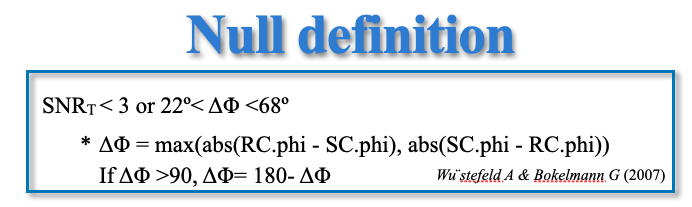

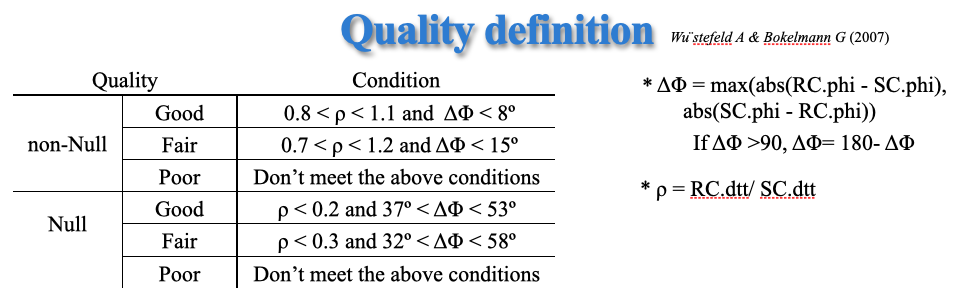



In [17]:
def Calc_rho(RCdt, SCdt):
    rho = RCdt/SCdt 
    return rho
def Calc_Phi(RCPhi, SCPhi):
    Phi = max (abs(RCPhi-SCPhi), abs(SCPhi-RCPhi))
    if Phi > 90: Phi = 180 - Phi
    return Phi
def RCcoeff(DATApath,NET,STA,event):
    RCfile = glob.glob(f'{DATApath}/{NET}.{STA}/{event}/RC_res_manual.pkl')[0]
    RCpkl  = pickle.load(open(RCfile, "rb"))
    coeff  = abs(RCpkl.errc)
    return coeff

## Quality Good

BAUR 20140218_092714 Good
BYUR 20130514_003226 Good
TSAP 20130406_044236 Good
GNI 20130514_003226 Good
GNI 20140218_092714 Good
TRLT 20111114_040512 Good
GANJ 20111014_033515 Good
ZARN 20140824_232141 Good
ZARN 20140824_232143 Good
ZARN 20150323_045137 Good
AKH 20120514_100039 Good
AKH 20120706_022822 Good
AKH 20130704_171557 Good
AKH 20140316_211628 Good
AKH 20140323_182001 Good
AKH 20140403_015829 Good
AKH 20140824_232141 Good
AKH 20140824_232143 Good
ONI 20140316_211628 Good
ONI 20140403_015829 Good
ONI 20140824_232141 Good
ONI 20140824_232143 Good
ONI 20140924_111613 Good
ONI 20150323_045137 Good
ONI 20150928_152805 Good
TBLG 20120205_001540 Good
TBLG 20120514_100039 Good
TBLG 20130717_023743 Good
TBLG 20140316_211628 Good
TBLG 20140323_182001 Good
KIV 20110306_123158 Good
KIV 20110902_134710 Good
KIV 20120607_040504 Good
KIV 20140924_111613 Good
GNI 20110824_174611 Good
GNI 20111122_184816 Good
GNI 20120802_093831 Good
GNI 20150610_135208 Good
ABST 20120305_074609 Good
ABST 201302

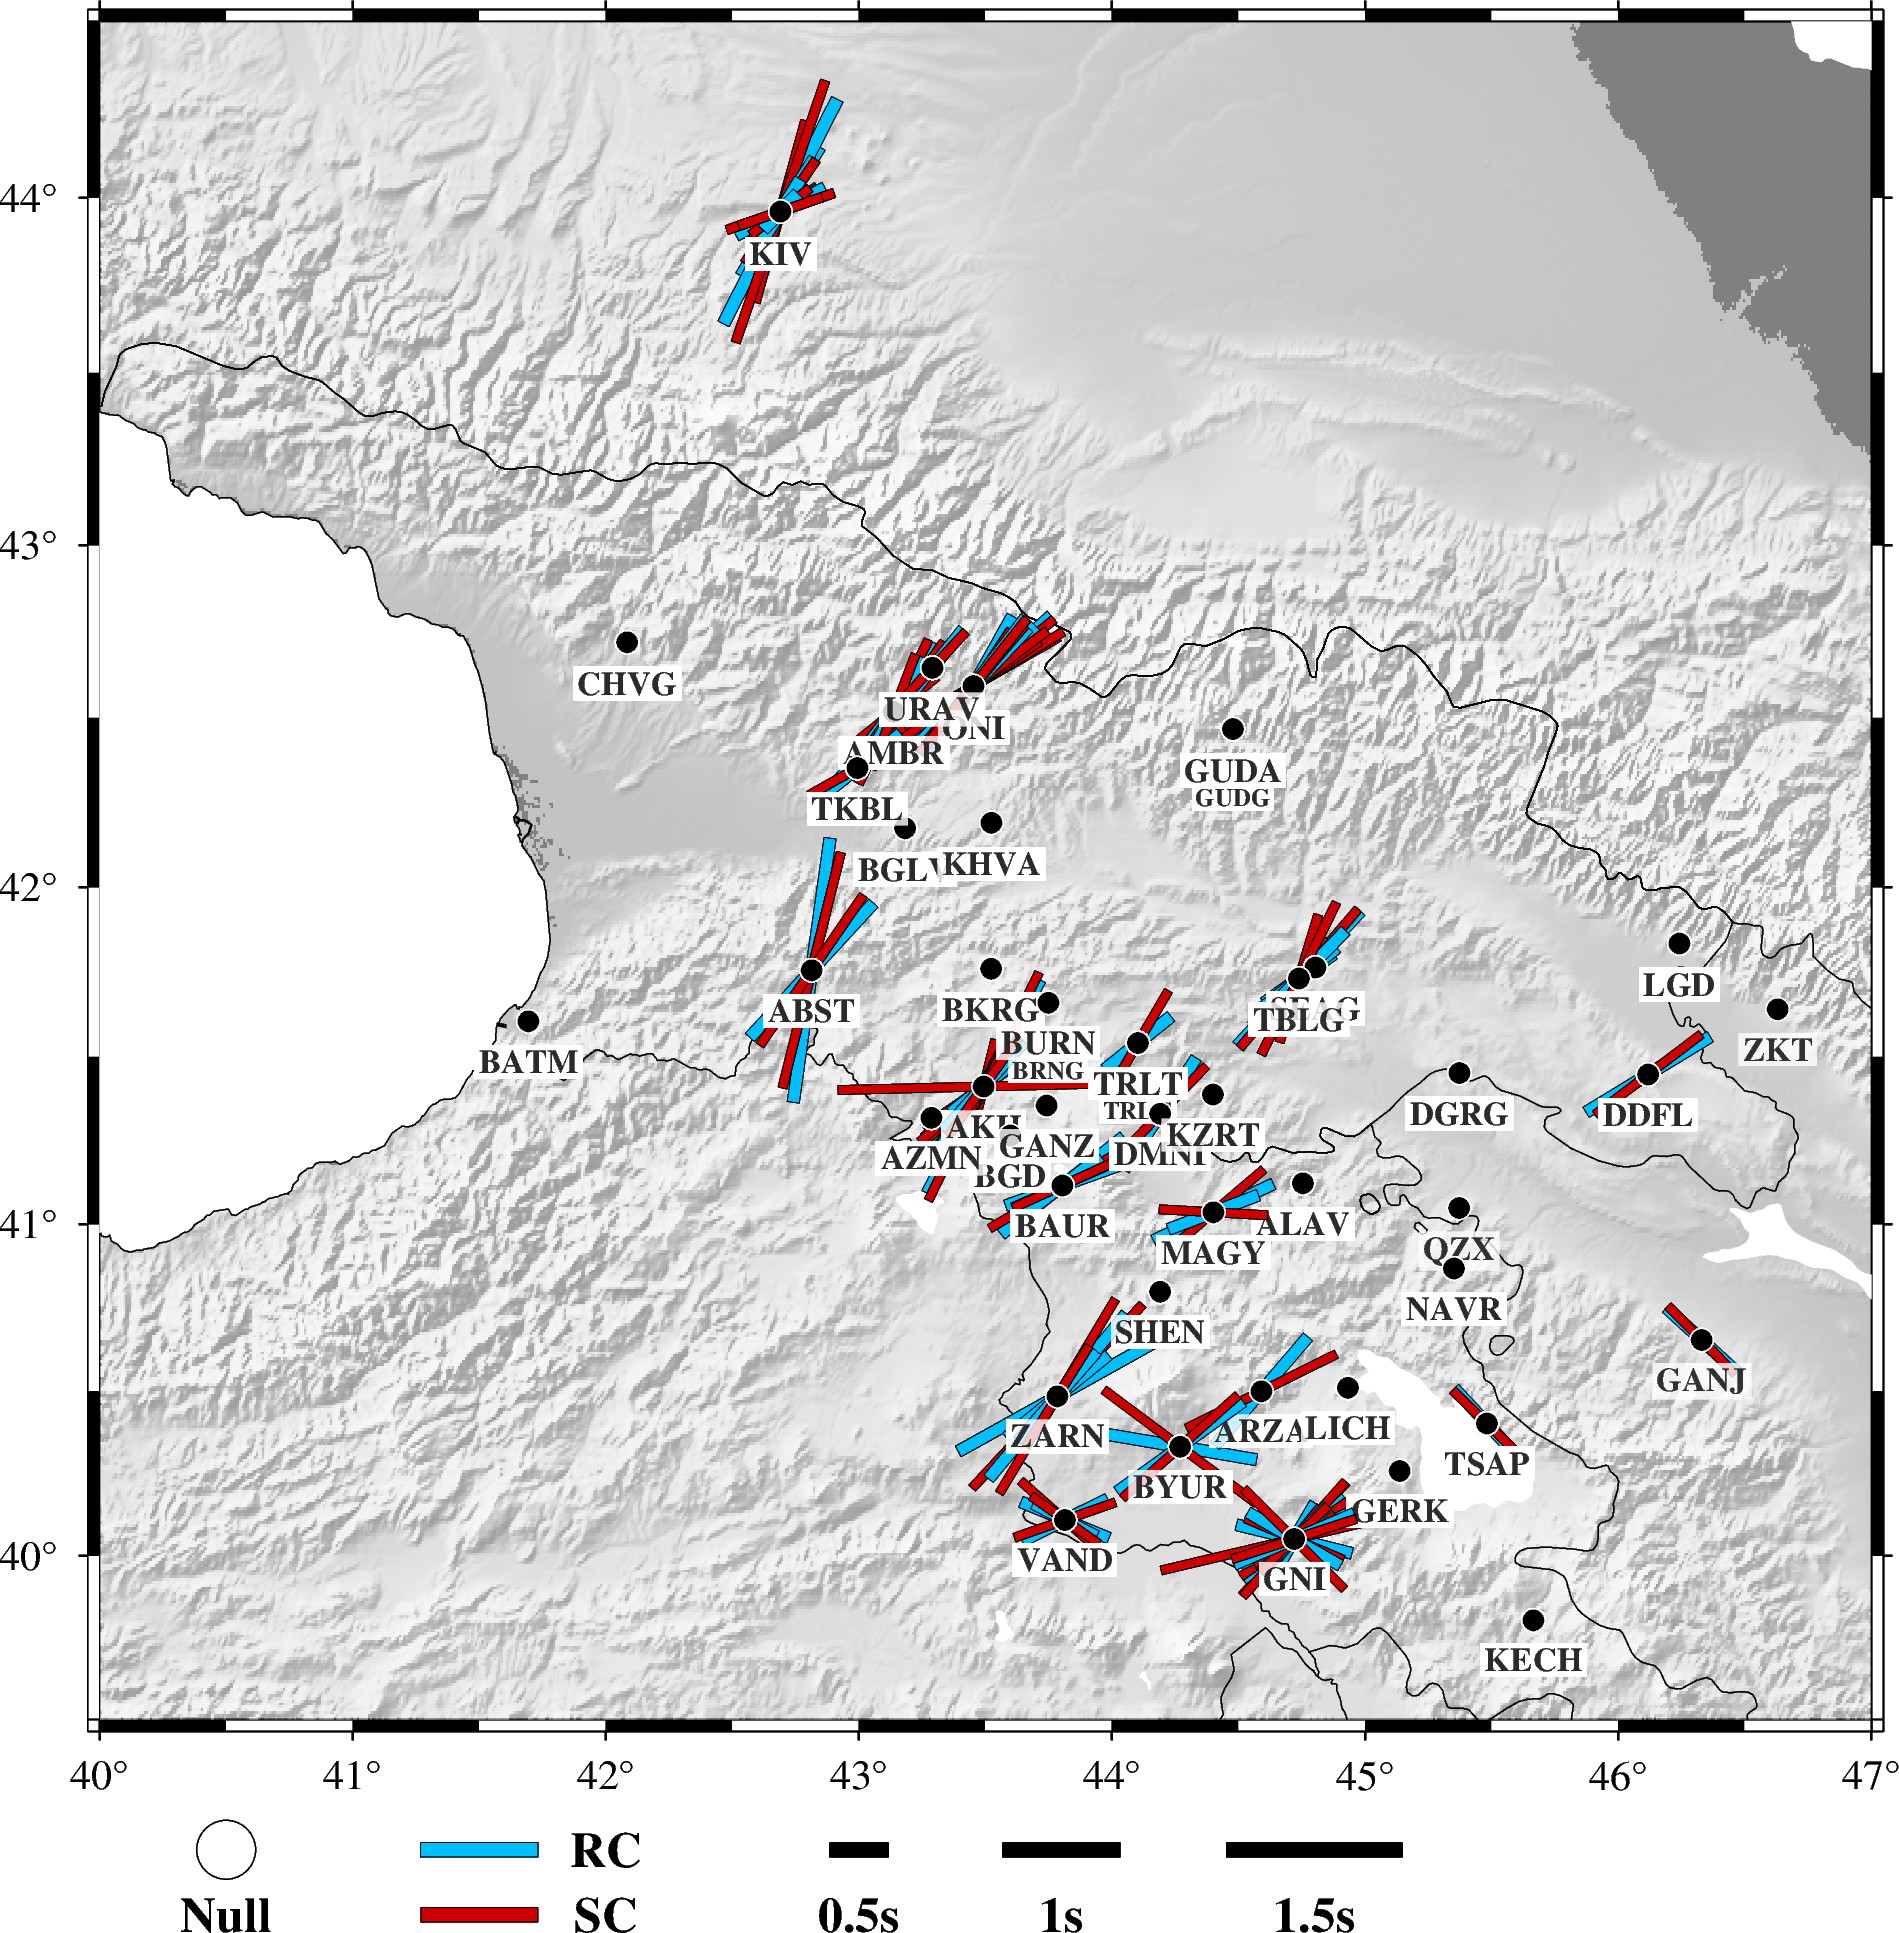

In [19]:
##==================for non-Null Good condition 
# Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]
    
    
    for i in range(len(df)):
        evtTime = df["Event"].values[i]
        RCPhi = df['RCPhi'].values[i]
        RCdt  = df['RCdt'].values[i]
        RCPhi_std = df['RCPhi_std'].values[i]
        RCdt_std  = df['RCdt_std'].values[i]
        SCPhi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]
        SCPhi_std = df['SCPhi_std'].values[i]
        SCdt_std  = df['SCdt_std'].values[i]   
        CpH = df['CpH'].values[i]   

        rho = Calc_rho(RCdt, SCdt)
        phi = Calc_Phi(RCPhi, SCPhi)
        coeff = RCcoeff(DATApath,NET,STA,evtTime)

        if CpH <=0.76 and SCdt<2.5 :
            if (SCPhi_std <20 and SCdt_std<0.5 and coeff >=0.8):
                print(f'{STA} {evtTime} Good')
                RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
                figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")
                SCdata = [[st_lon, st_lat, SCPhi-90, 3, SCdt*40]]
                figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black") 
            elif phi <10:
                print(f'{STA} {evtTime} Good')
                RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
                figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")
                SCdata = [[st_lon, st_lat, SCPhi-90, 3, SCdt*40]]
                figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black") 
            # elif (SCPhi_std <=30 and SCdt_std<=1.0 and coeff >=0.8) :
            #     print(f'{STA} {evtTime} Fair')
            # elif (10 <= phi <25): 
            #     print(f'{STA} {evtTime} Fair')
            # else:
            #     # pass
            #     print(f'{STA} {evtTime} Poor')
        else:
            if CpH >=0.9:
                pass
                
        
    figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white")
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)


figmap.show()

## Quality Fair

BYUR 20130406_044236 Fair
KIV 20110909_194133 Fair
GNI 20141206_220510 Fair
BATM 20130406_044236 Fair
BRNG 20150227_134505 Fair
DDFL 20130901_115232 Fair
DDFL 20141206_220510 Fair
DMNI 20150227_134505 Fair
LGD 20140515_081636 Fair
TKBL 20110830_065741 Fair
GANJ 20110830_065741 Fair
GANJ 20110909_194133 Fair
QZX 20111117_015704 Fair
ARZA 20140316_211628 Fair
NAVR 20150916_140322 Fair
ZARN 20150211_185720 Fair
AKH 20121119_094435 Fair
AKH 20130717_023743 Fair
GUDG 20140316_211628 Fair
ONI 20121214_103601 Fair
ONI 20140729_132740 Fair
ONI 20140729_132747 Fair
ONI 20150211_185720 Fair
ONI 20150610_135208 Fair
TBLG 20120607_160318 Fair
TBLG 20120725_112027 Fair
KIV 20111122_184816 Fair
KIV 20120802_093831 Fair
KIV 20140823_223223 Fair
GNI 20110306_123158 Fair
GNI 20150211_185720 Fair
GNI 20150928_152805 Fair
ABST 20110306_123158 Fair
AMBR 20120514_100039 Fair
AMBR 20120528_050723 Fair
BRNG 20150211_185720 Fair
TKBL 20110620_163600 Fair
TKBL 20110824_174611 Fair
TKBL 20111028_185434 Fair
TRL

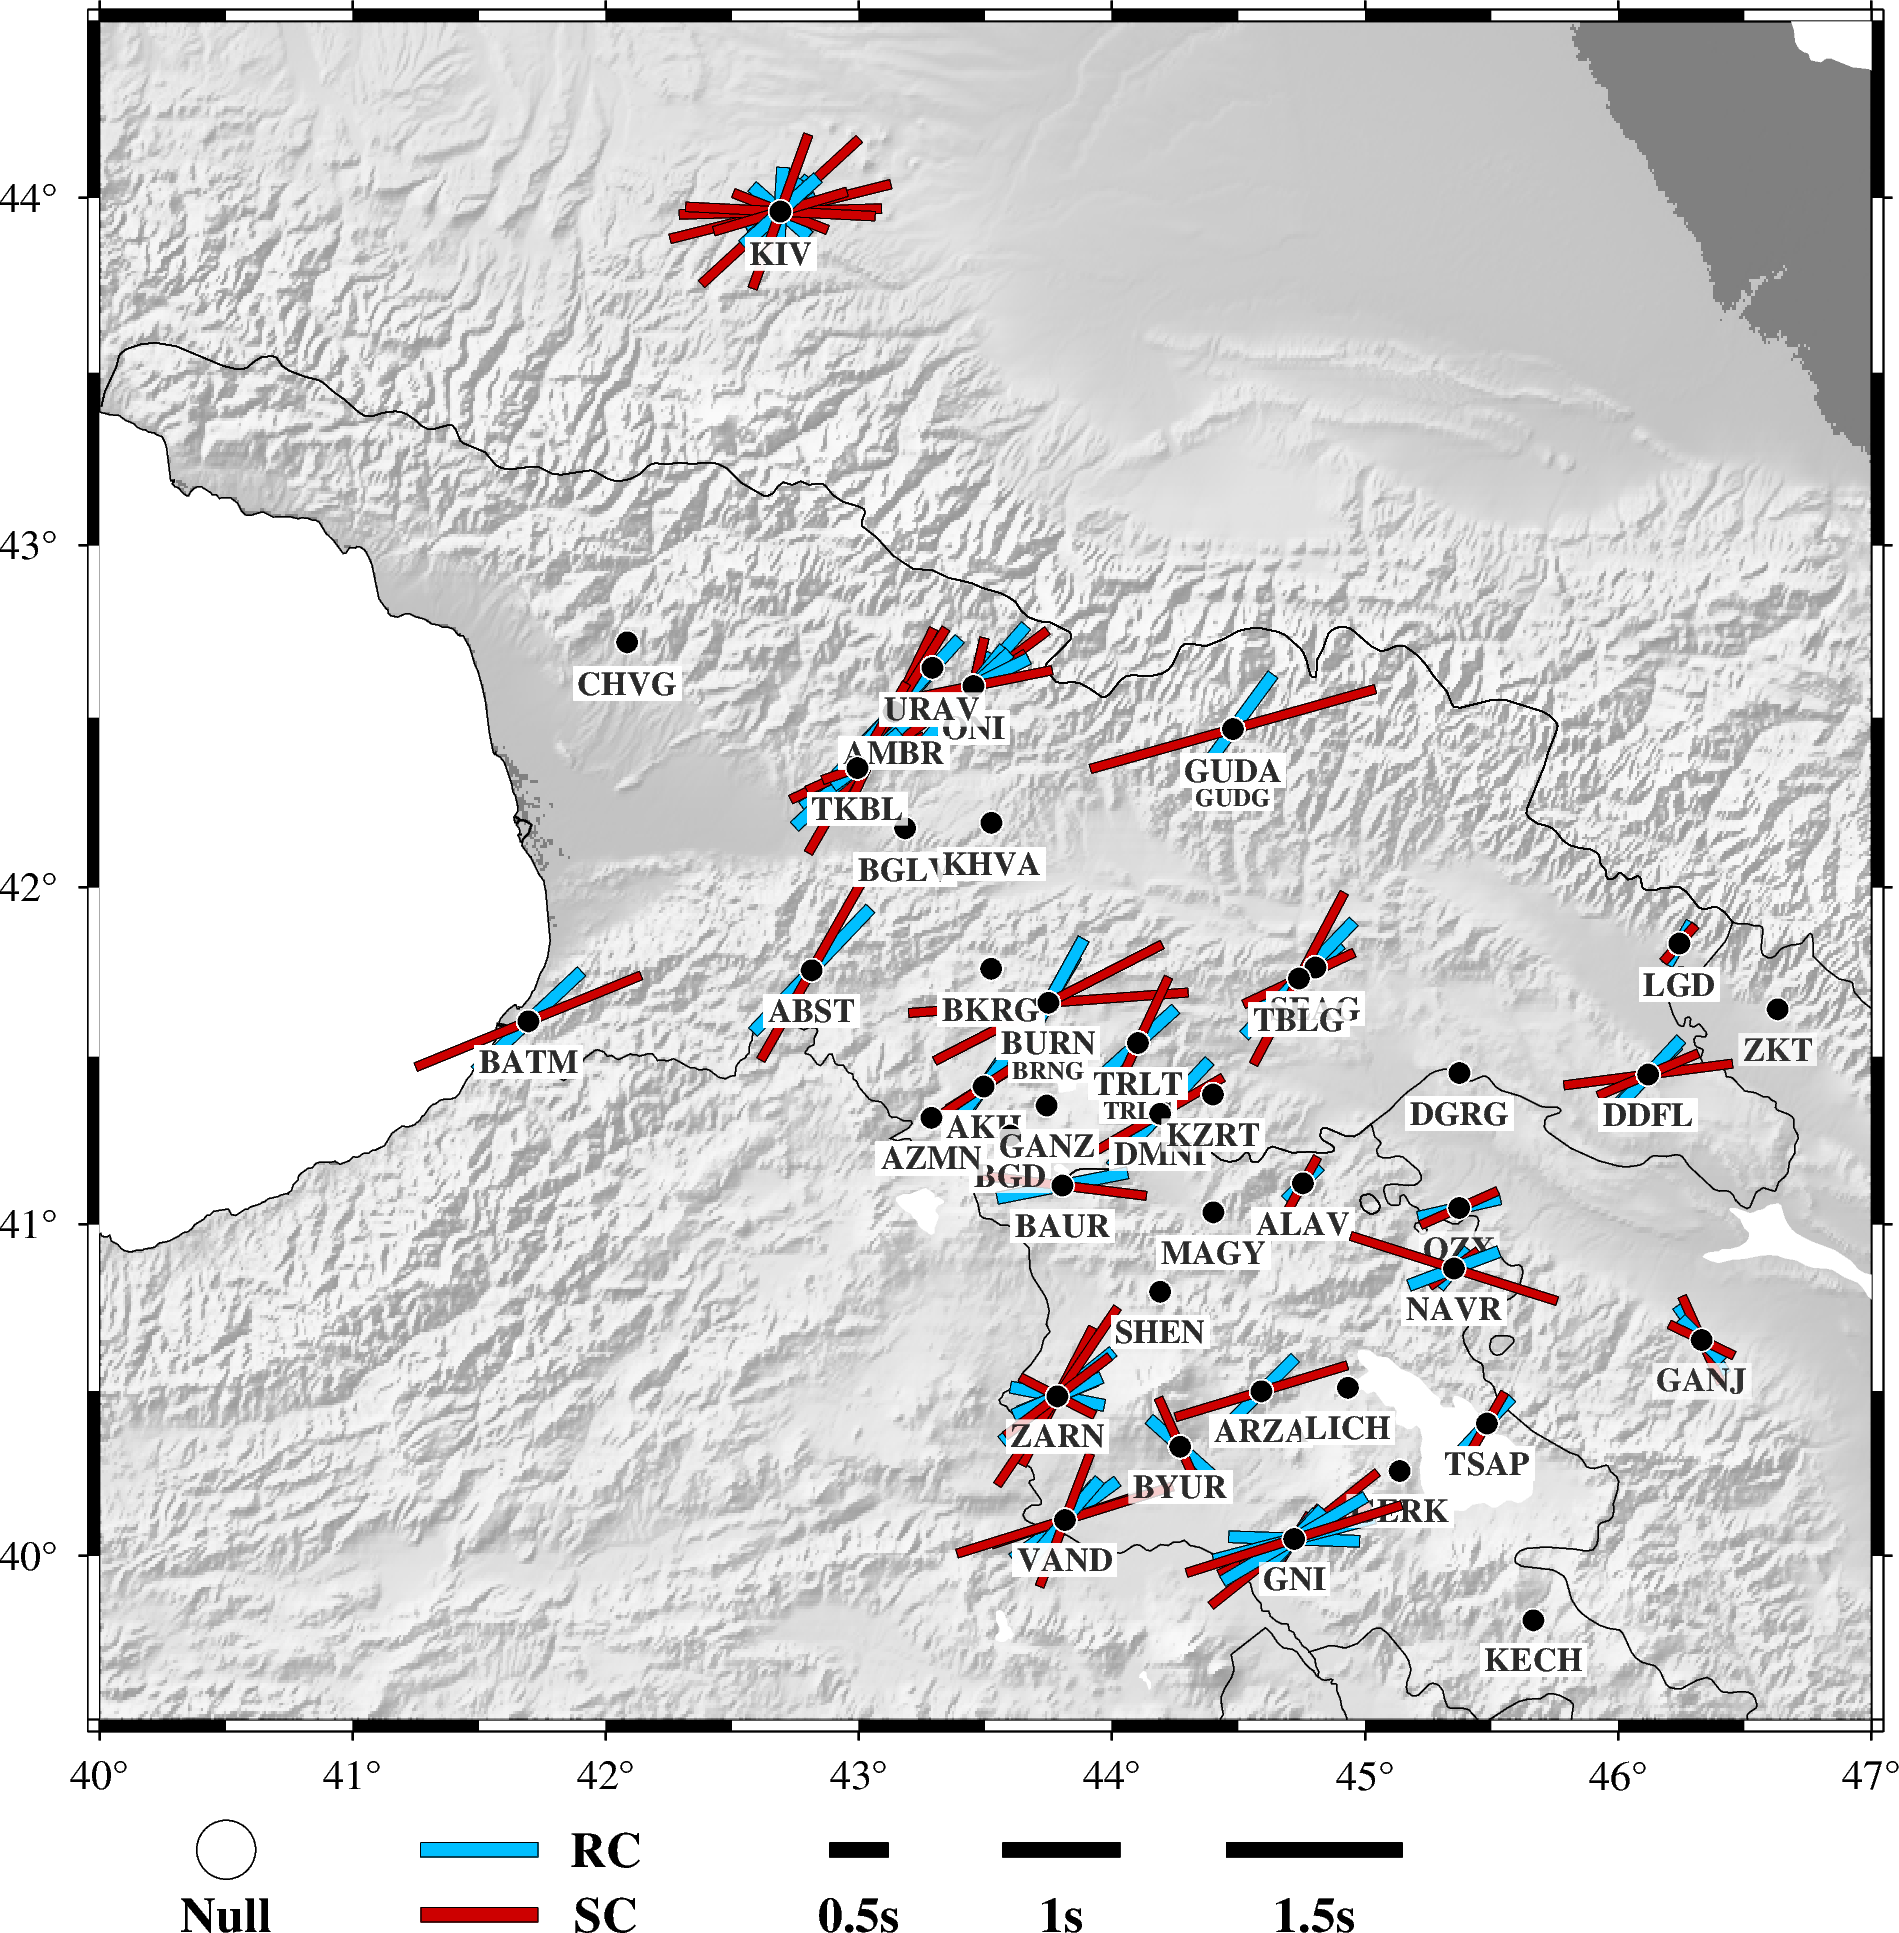

In [20]:
##==================for non-Null FAIR condition 
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]
    
    
    for i in range(len(df)):
        evtTime = df["Event"].values[i]
        RCPhi = df['RCPhi'].values[i]
        RCdt  = df['RCdt'].values[i]
        RCPhi_std = df['RCPhi_std'].values[i]
        RCdt_std  = df['RCdt_std'].values[i]
        SCPhi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]
        SCPhi_std = df['SCPhi_std'].values[i]
        SCdt_std  = df['SCdt_std'].values[i]   
        CpH = df['CpH'].values[i]   

        rho = Calc_rho(RCdt, SCdt)
        phi = Calc_Phi(RCPhi, SCPhi)
        coeff = RCcoeff(DATApath,NET,STA,evtTime)

        if CpH <=0.76 and SCdt<2.5:
            if (SCPhi_std <20 and SCdt_std<0.5 and coeff >=0.8):
                pass
                # print(f'{STA} {evtTime} Good')
            elif phi <10:
                pass
                #  print(f'{STA} {evtTime} Good')
            elif (SCPhi_std <=30 and SCdt_std<=1.0 and coeff >=0.8) :
                print(f'{STA} {evtTime} Fair')
                RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
                figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")
                SCdata = [[st_lon, st_lat, SCPhi-90, 3, SCdt*40]]
                figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black") 
            elif (10 <= phi <25): 
                print(f'{STA} {evtTime} Fair')
                RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
                figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")
                SCdata = [[st_lon, st_lat, SCPhi-90, 3, SCdt*40]]
                figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black") 
            # else:
            #     # pass
            #     print(f'{STA} {evtTime} Poor')
        else:
            if CpH >=0.9:
                pass
    figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white")
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)

figmap.show()

## Quality Poor 

BCA Quality Poor: 1.3636363636363635 10.0 8.55 False
BCA 20131123_074832
BCA Quality Poor: 0.6190476190476191 18.0 6.6 False
BCA 20140721_145441


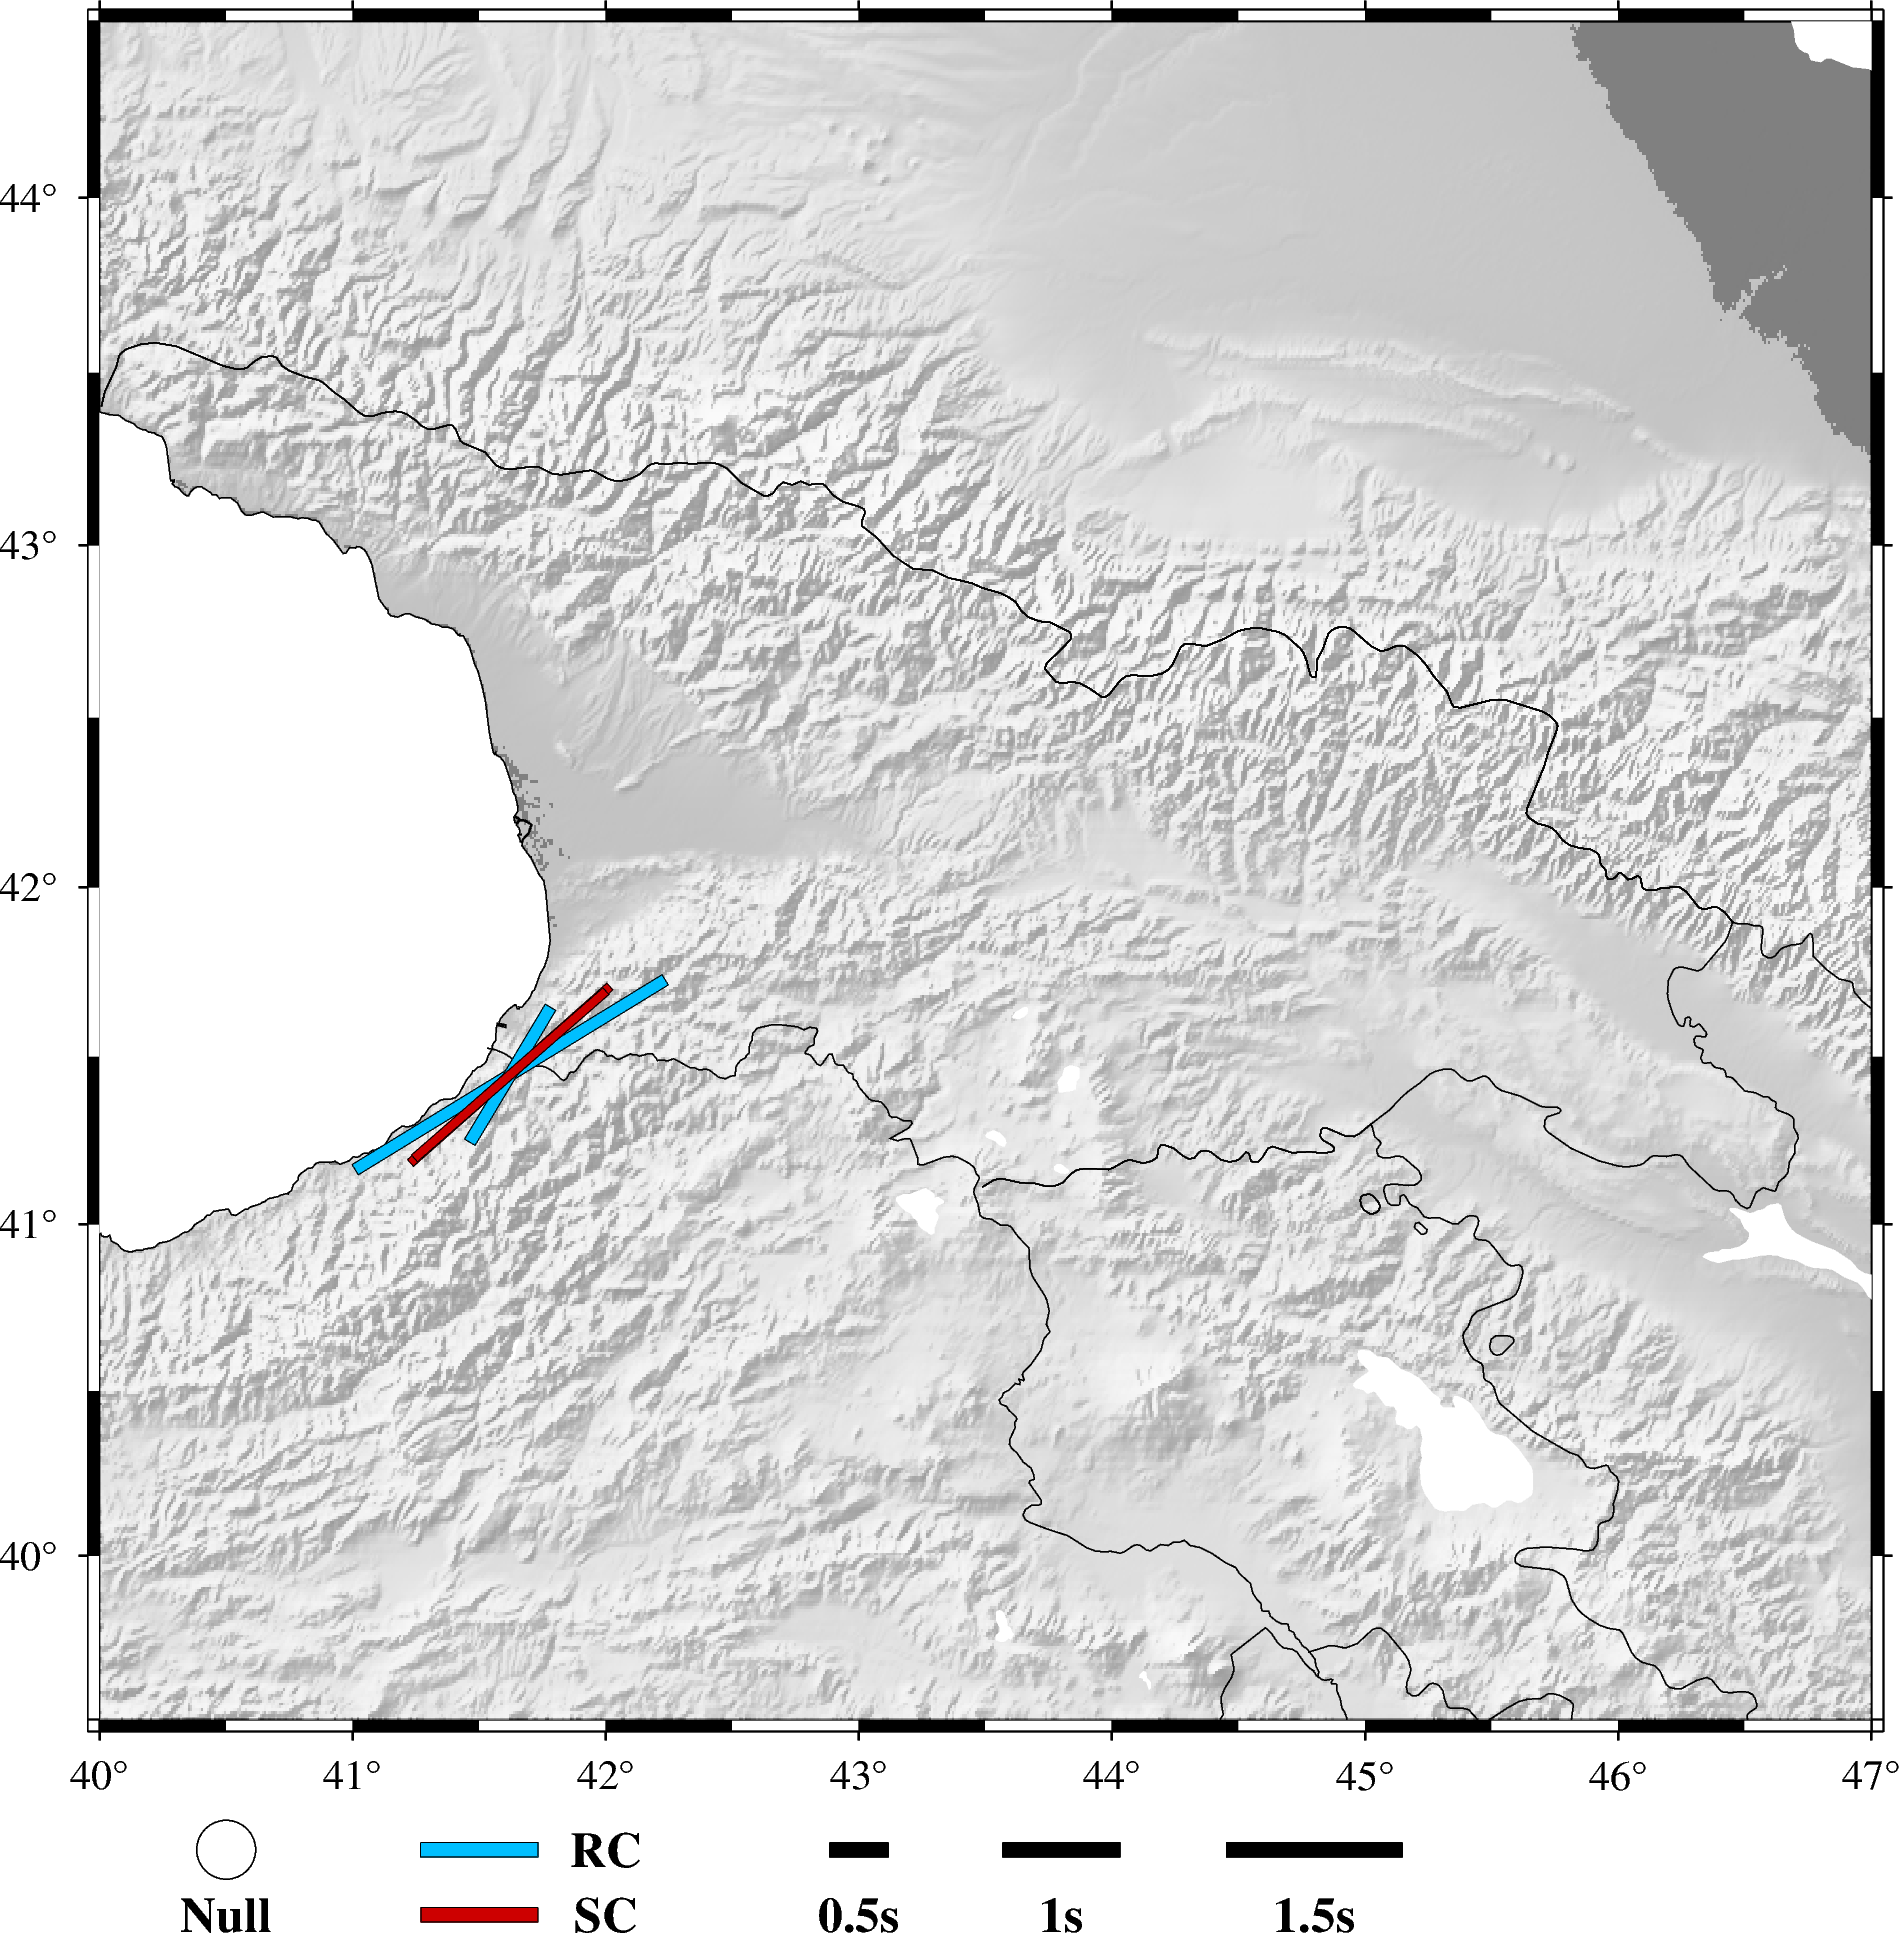

In [17]:
##==================for non-Null Poor condition 
# Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']<7]
    
    
    for i in range(len(df)):
        RCPhi = df['RCPhi'].values[i]
        RCdt  = df['RCdt'].values[i]
        SCPhi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]
        
        rho = Calc_rho(RCdt, SCdt)
        phi = Calc_Phi(RCPhi, SCPhi)
        if 25 < phi < 68 or df["CpH"].values[i] >= 0.77 : pass
        else:         
            if 0.8 < rho < 1.1 and phi < 8:   ## non-null good condition 
    #             print(f'{STA} Quality Good')
                pass
            elif 0.7 <= rho < 1.2 and phi <= 25: ## non-null FAIR condition 
    #             print(f'{STA} Quality FAIR')
                pass
#             elif rho > 0.3 and 15 < phi <32 and df['CpH'].values[i] <= 0.76:
            else:
                print(f'{STA} Quality Poor: {rho} {phi} {df["SNRT"].values[i]} {df["Null"].values[i]}' )
                RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
                figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")
                SCdata = [[st_lon, st_lat, SCPhi-90, 3, SCdt*40]]
                figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black")   

                evtTime = df["Event"].values[i]
                print(f'{STA} {evtTime}')
                if evtTime not in USEevent:   
                    USEevent.append(evtTime)
                     
#     figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white")
#     if STA not in notplotLIST :
#         figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
#     else : 
#         figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)



# ##============= clean up catalog I used 
# Event = Ori_Event.copy()
# removelist = [x for x in Event['Time'] if x not in USEevent]
# for reevent in removelist:
#     index = Event['Time'].index(reevent)
#     for keys in Event:
#         Event[keys].pop(index)
# NEWEvent=pd.DataFrame(Event)    
# num_evt = len(NEWEvent)
# figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)    
# #============= plot earthquake distribution  
# Plot_event(figmap, NEWEvent)

# figmap.savefig(f'{SAVEpath}/07_Plot_Station_nonnull_poor_{filemag}.png')
# figmap.savefig(f'{SAVEpath}/07_Plot_Station_nonnull_poor_{filemag}.pdf')
figmap.show()

## Quality Null

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/1) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 224 degrees.


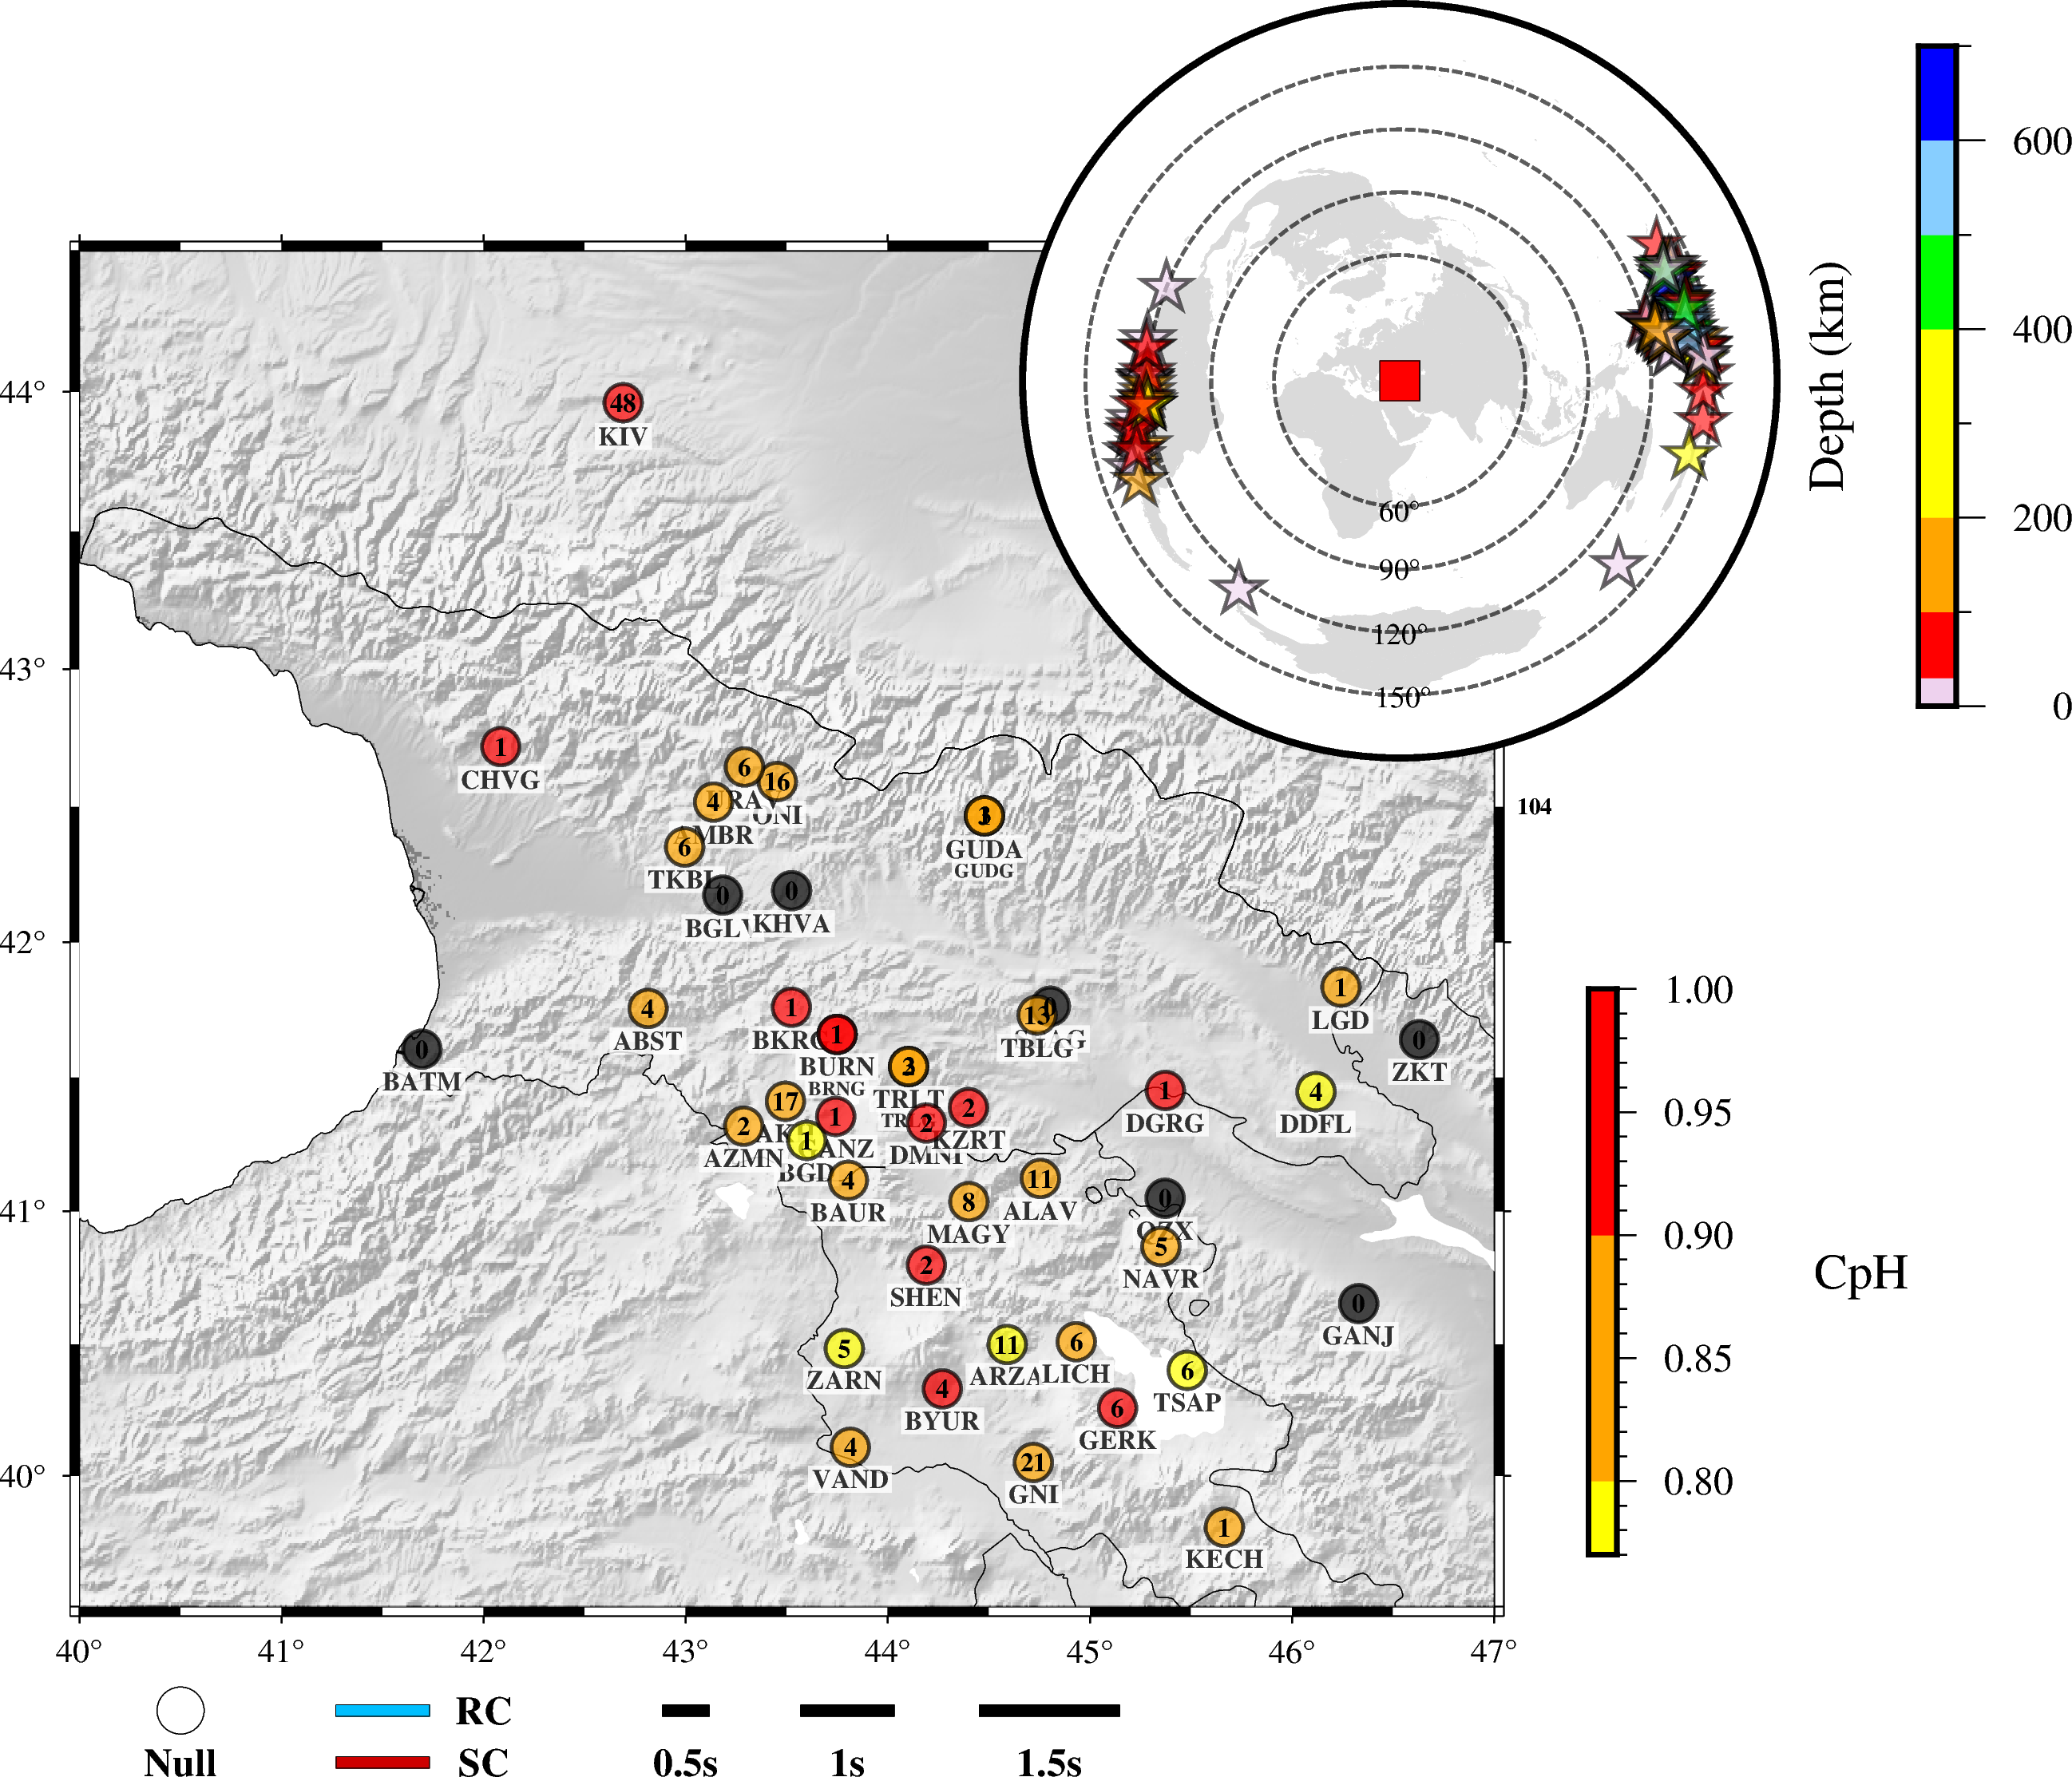

In [11]:
##==================for non-Null Poor condition 
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
CpHINFO={'Lat':[], 'Lon':[],'CpH':[], 'Num':[]}

# pygmt.makecpt(cmap="hot", series=[0.5, 1], reverse=True,out put = 'cmapCpH.cpt')
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']<7]
    
    CphList = []
#     print(STA)
    for i in range(len(df)):
        RCPhi = df['RCPhi'].values[i]
        RCdt  = df['RCdt'].values[i]
        SCPhi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]
        
        rho = Calc_rho(RCdt, SCdt)
        phi = Calc_Phi(RCPhi, SCPhi)
        if 26 < phi < 68 or df["CpH"].values[i] >= 0.77: 
#             if rho <= 0.3 and 32 < phi < 58 and df['CpH'].values[i] > 0.76:
#             print(f'{STA} Quality Null: {rho} {phi} {df["SNRT"].values[i]} {df["Null"].values[i]}' )       
            CpH = df['CpH'].values[i]
            CphList.append(CpH)

            evtTime = df["Event"].values[i]
            if evtTime not in USEevent:   
                USEevent.append(evtTime)
        else: 
            if 0.8 < rho < 1.1 and phi < 8:   ## non-null good condition 
    #             print(f'{STA} Quality Good')
                pass
            elif 0.7 < rho < 1.2 and phi <= 25: ## non-null FAIR condition 
    #             print(f'{STA} Quality FAIR')
                pass
            elif rho > 0.3 and 15 < phi < 32 and df['CpH'].values[i] <= 0.76:
                pass

                
            
    avg_CpH = np.mean(CphList)
    len_CpH = len(CphList)
    CpHINFO['Lat'].append(st_lat)
    CpHINFO['Lon'].append(st_lon)
    CpHINFO['CpH'].append(avg_CpH)
    CpHINFO['Num'].append(len_CpH)

    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)

figmap.plot(x=CpHINFO['Lon'],y=CpHINFO['Lat'], color = CpHINFO['CpH'],
            cmap = 'cmapCpH.cpt', style="c0.4c", pen="1p,black" ,transparency=30)
figmap.text(x=CpHINFO['Lon'],y=CpHINFO['Lat'],text=CpHINFO['Num'],font="8p,Times-Bold,black")

with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                  MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                  MAP_LABEL_OFFSET = '0.5c', 
                  MAP_TICK_LENGTH_PRIMARY = '0.2c',
                  MAP_FRAME_PEN = '1.5p'): 
    figmap.colorbar(cmap = 'cmapCpH.cpt', position = 'x16/0.55+w6c/0.3c+mh', frame = ['a0.1f0.05','+L"CpH"'])

##============= clean up catalog I used 
Event = Ori_Event.copy()
removelist = [x for x in Event['Time'] if x not in USEevent]
for reevent in removelist:
    index = Event['Time'].index(reevent)
    for keys in Event:
        Event[keys].pop(index)
NEWEvent=pd.DataFrame(Event)    
num_evt = len(NEWEvent)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)    
#============= plot earthquake distribution  
Plot_event(figmap, NEWEvent)


# figmap.savefig(f'{SAVEpath}/04_Plot_Station_null_{filemag}.pdf')
# figmap.savefig(f'{SAVEpath}/04_Plot_Station_null_{filemag}.png')
figmap.show()